In [1]:
import pandas as pd

from PIL import Image

from PIL import ImageEnhance

import numpy as np

import io

import os

from pyspark.sql import SparkSession

from pyspark.sql.functions import col, pandas_udf, udf, PandasUDFType, size

from pyspark import SparkContext, SparkConf

import tensorflow as tf

from tensorflow.keras.models import Model

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras.preprocessing.image import img_to_array

# Create spark session

In [2]:
# create a spark session
spark = (SparkSession.builder
.master('local[2]')
.appName('Transfert learning')
.config('spark.driver.extraClassPath', 
        '/home/demo/hadoop/hadoop-3.2.2/share/hadoop/tools/lib/aws-java-sdk-bundle-1.11.375.jar:/home/demo/hadoop/hadoop-3.2.2/share/hadoop/tools/lib/hadoop-aws-3.2.0.jar:/home/demo/spark-avro_2.11:4.0.0.jar')         
.config('spark.executor.heartbeatInterval', '800000')
.config('spark.network.timeout', '900000')  
.config("spark.sql.execution.arrow.pyspark.enabled", "true")
.getOrCreate()
        )

# Load images from local storage

In [3]:
path_to_images = 'fruits-360/Training_apples/'
path_offset = len('file:/mnt/c/Users/demo/Desktop/Projet08/'+path_to_images)

In [4]:
images =(spark
         .read
         .format("binaryFile")
         .option("pathGlobFilter", "*.jpg")
         .option("recursiveFileLookup", "true")
         .load(path_to_images)
        )

images.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



## Retrieve labels from image path

In [5]:
#Get only fruit name from path
from pyspark.sql.functions import udf
from pyspark.sql import types 

col_label = udf(lambda s : extract_label(s), types.StringType())

def extract_label(s):
    last = s[path_offset :]
    return last[:last.rfind('/')]

In [6]:
images = images.withColumn('label',col_label(images.path))
images.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)



In [7]:
#Get only fruit name from path
images.select('label').show(truncate=False)

+--------------+
|label         |
+--------------+
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
|Apple Red 1   |
|Apple Red 1   |
|Apple Braeburn|
|Apple Red 1   |
|Apple Braeburn|
|Apple Braeburn|
|Apple Braeburn|
+--------------+
only showing top 20 rows



In [8]:
# By label count
print('By label images count :')
images.groupBy('label').count().show(13)

By label images count :
+---------------+-----+
|          label|count|
+---------------+-----+
| Apple Golden 3|  481|
|    Apple Red 2|  492|
|Apple Pink Lady|  231|
|    Apple Red 1|  248|
| Apple Braeburn|  248|
+---------------+-----+



# Images enhancement

In [9]:
sampleList = images.sample(0.001).select('path').toPandas()
display(sampleList.head(2))
sampleList.shape

path
0  file:/mnt/c/Users/demo/Desktop/Projet08/fruits...
1  file:/mnt/c/Users/demo/Desktop/Projet08/fruits...

(2, 1)

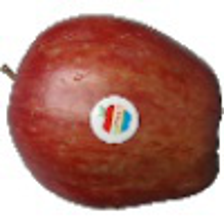

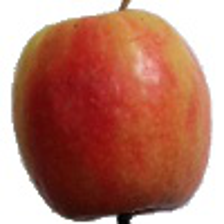

In [10]:
# Image samples
imgs = [Image.open(path[5:]).resize([224, 224]) for path in sampleList.path]
for _,img in enumerate(imgs):
    img.show()

## Color balance

Color 0.000000


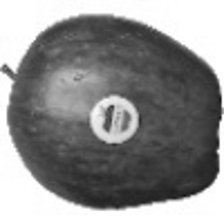

Color 0.125000


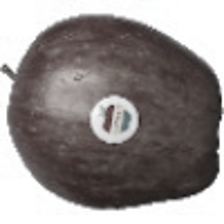

Color 0.250000


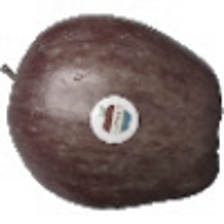

Color 0.375000


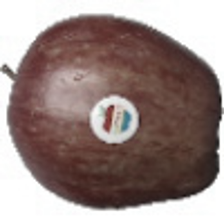

Color 0.500000


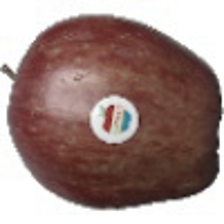

Color 0.625000


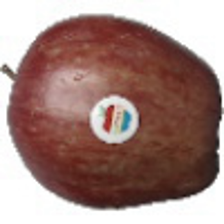

Color 0.750000


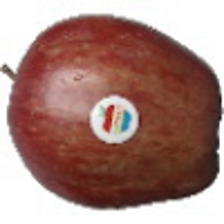

Color 0.875000


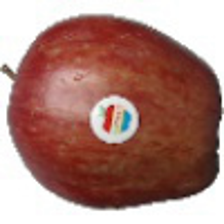

Color 1.000000


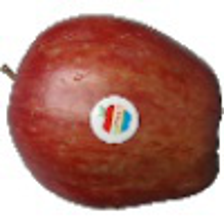

Color 1.125000


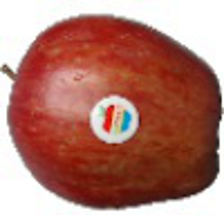

Color 1.250000


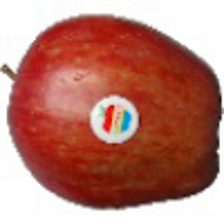

Color 1.375000


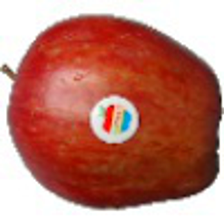

Color 1.500000


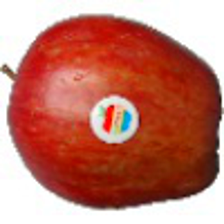

Color 1.625000


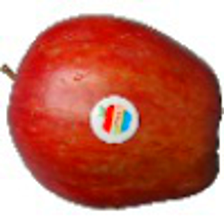

Color 1.750000


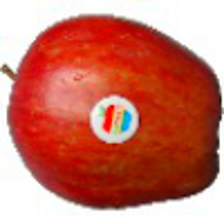

Color 1.875000


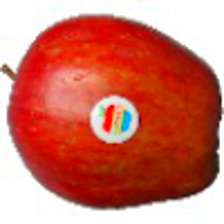

Color 2.000000


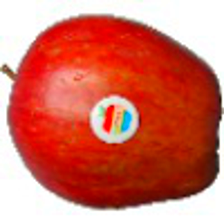

Color 2.125000


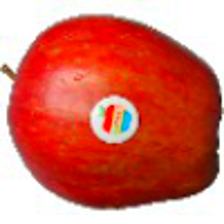

Color 2.250000


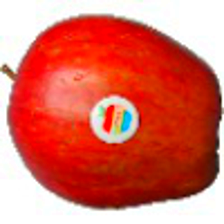

Color 2.375000


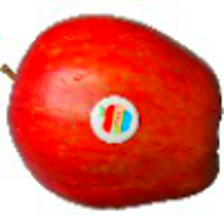

Color 2.500000


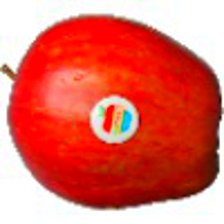

Color 2.625000


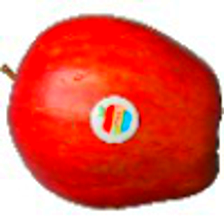

Color 2.750000


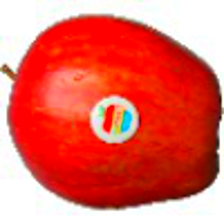

Color 2.875000


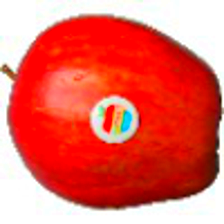

Color 3.000000


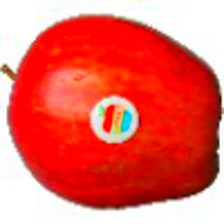

Color 3.125000


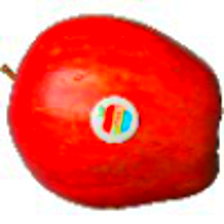

Color 3.250000


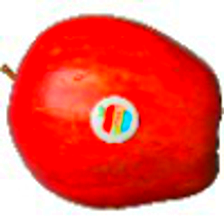

Color 3.375000


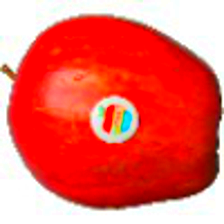

Color 3.500000


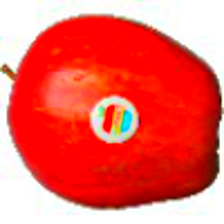

Color 3.625000


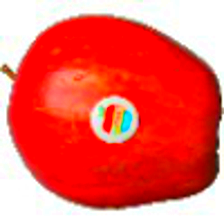

Color 3.750000


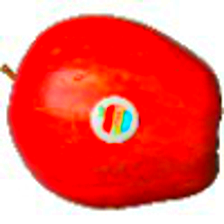

Color 3.875000


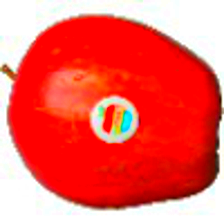

Color 4.000000


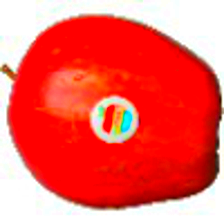

Color 4.125000


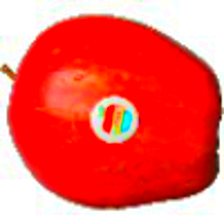

Color 4.250000


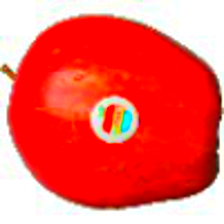

Color 4.375000


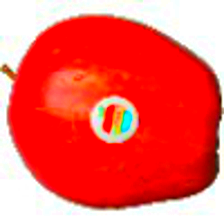

Color 4.500000


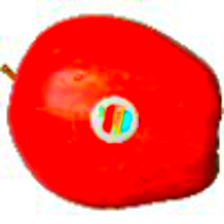

Color 4.625000


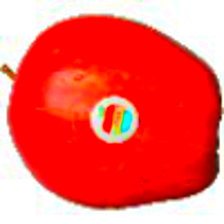

Color 4.750000


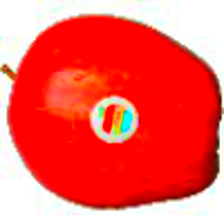

Color 4.875000


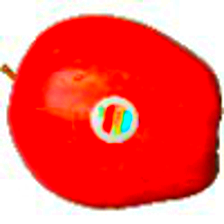

In [11]:
colorEnhancer = ImageEnhance.Color(imgs[0])

for i in range(40):
    factor = i / 8
    print(f"Color {factor:f}")
    colorEnhancer.enhance(factor).show()

## Sharpness

Sharpness 0.000000


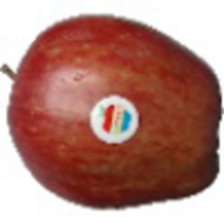

Sharpness 0.125000


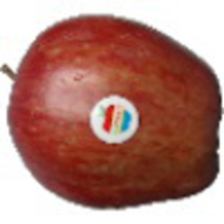

Sharpness 0.250000


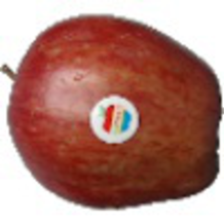

Sharpness 0.375000


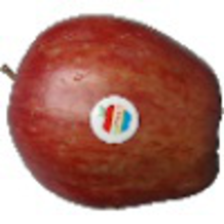

Sharpness 0.500000


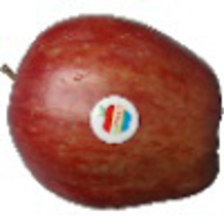

Sharpness 0.625000


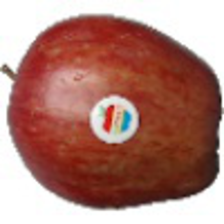

Sharpness 0.750000


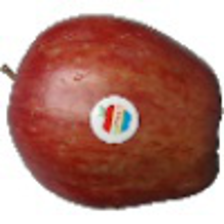

Sharpness 0.875000


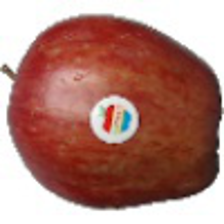

Sharpness 1.000000


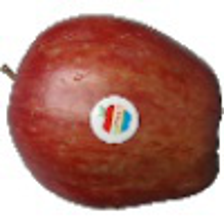

Sharpness 1.125000


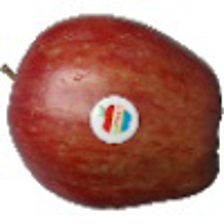

Sharpness 1.250000


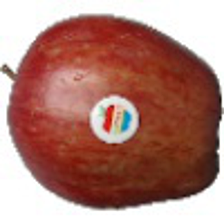

Sharpness 1.375000


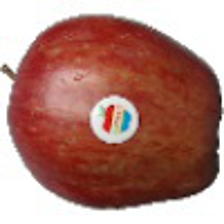

Sharpness 1.500000


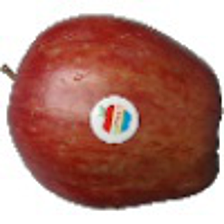

Sharpness 1.625000


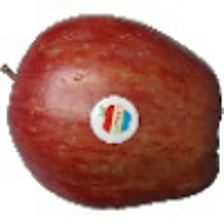

Sharpness 1.750000


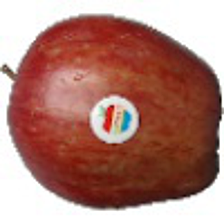

Sharpness 1.875000


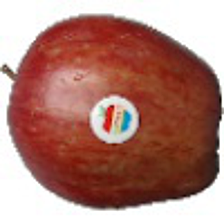

Sharpness 2.000000


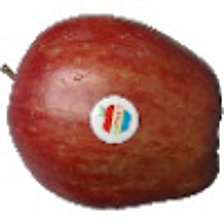

Sharpness 2.125000


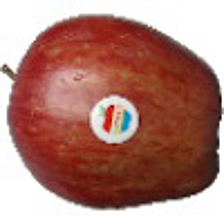

Sharpness 2.250000


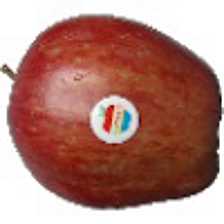

Sharpness 2.375000


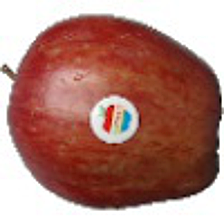

Sharpness 2.500000


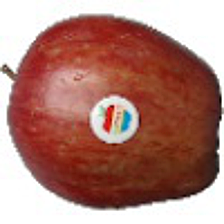

Sharpness 2.625000


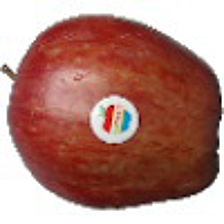

Sharpness 2.750000


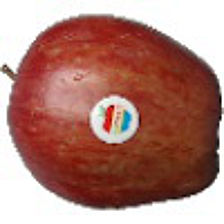

Sharpness 2.875000


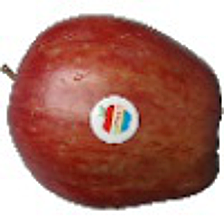

Sharpness 3.000000


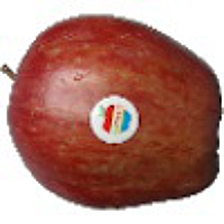

Sharpness 3.125000


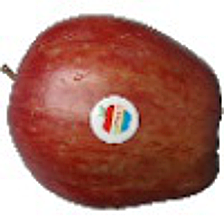

Sharpness 3.250000


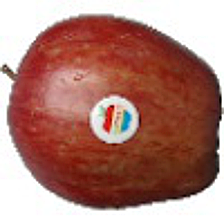

Sharpness 3.375000


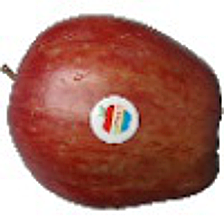

Sharpness 3.500000


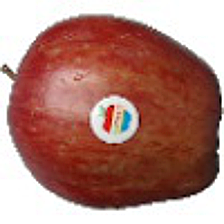

Sharpness 3.625000


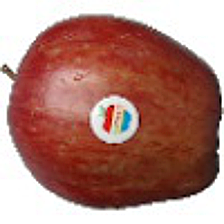

Sharpness 3.750000


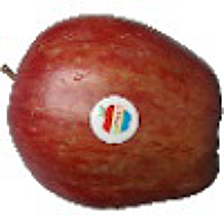

Sharpness 3.875000


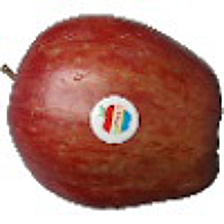

Sharpness 4.000000


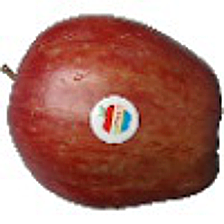

Sharpness 4.125000


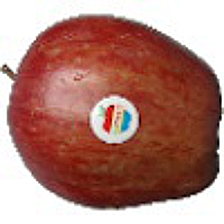

Sharpness 4.250000


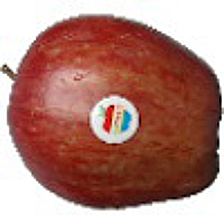

Sharpness 4.375000


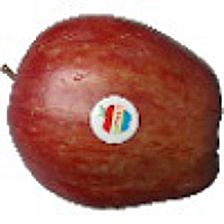

Sharpness 4.500000


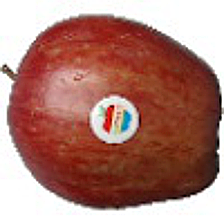

Sharpness 4.625000


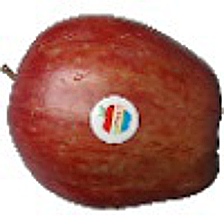

Sharpness 4.750000


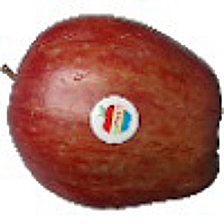

Sharpness 4.875000


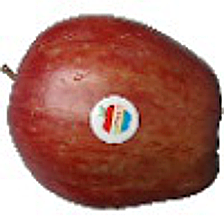

In [12]:
sharpnessEnhancer = ImageEnhance.Sharpness(imgs[0])

for i in range(40):
    factor = i / 8
    print(f"Sharpness {factor:f}")
    sharpnessEnhancer.enhance(factor).show()

## Contrast

Contrast 0.000000


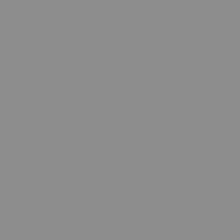

Contrast 0.125000


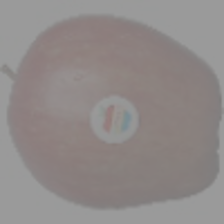

Contrast 0.250000


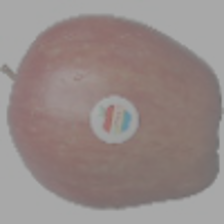

Contrast 0.375000


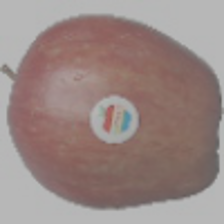

Contrast 0.500000


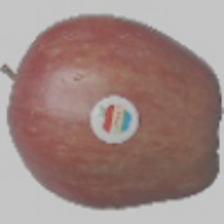

Contrast 0.625000


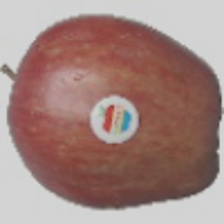

Contrast 0.750000


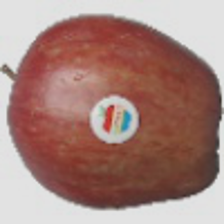

Contrast 0.875000


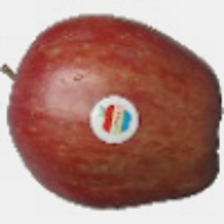

Contrast 1.000000


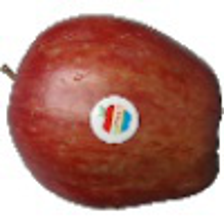

Contrast 1.125000


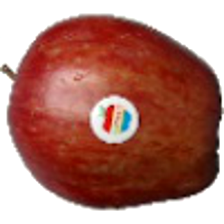

Contrast 1.250000


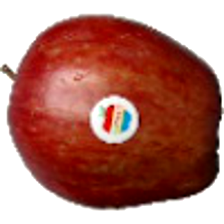

Contrast 1.375000


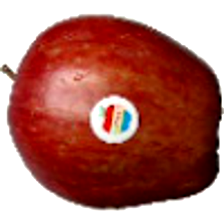

Contrast 1.500000


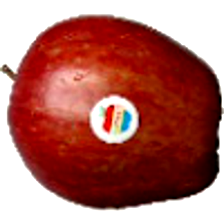

Contrast 1.625000


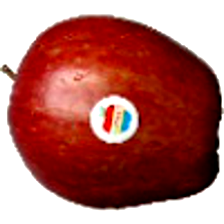

Contrast 1.750000


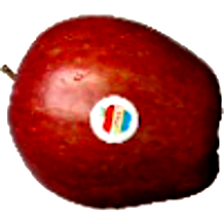

Contrast 1.875000


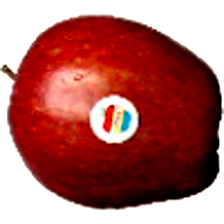

Contrast 2.000000


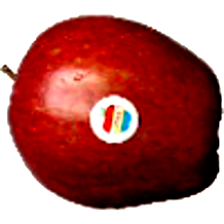

Contrast 2.125000


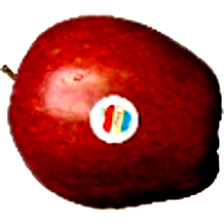

Contrast 2.250000


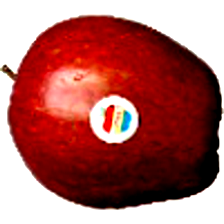

Contrast 2.375000


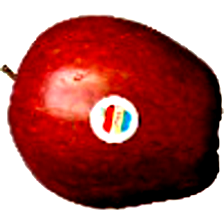

Contrast 2.500000


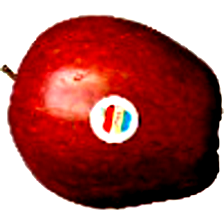

Contrast 2.625000


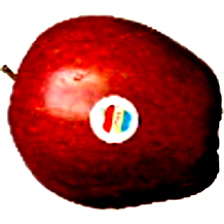

Contrast 2.750000


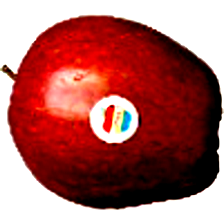

Contrast 2.875000


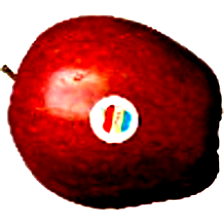

Contrast 3.000000


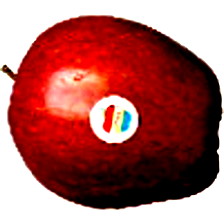

Contrast 3.125000


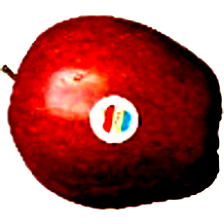

Contrast 3.250000


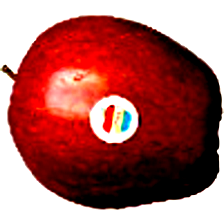

Contrast 3.375000


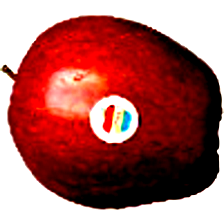

Contrast 3.500000


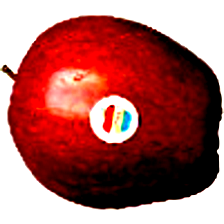

Contrast 3.625000


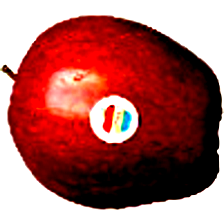

Contrast 3.750000


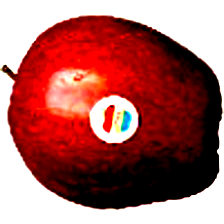

Contrast 3.875000


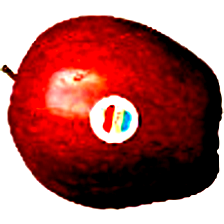

Contrast 4.000000


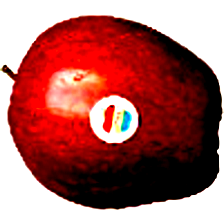

Contrast 4.125000


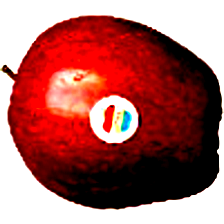

Contrast 4.250000


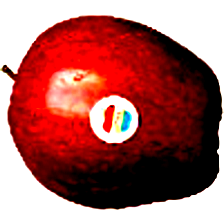

Contrast 4.375000


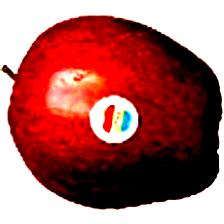

Contrast 4.500000


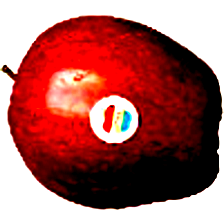

Contrast 4.625000


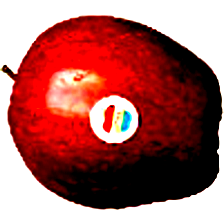

Contrast 4.750000


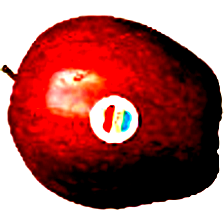

Contrast 4.875000


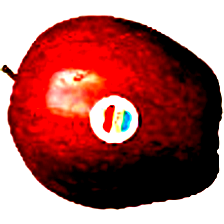

In [13]:
contrastEnhancer = ImageEnhance.Contrast(imgs[0])

for i in range(40):
    factor = i / 8
    print(f"Contrast {factor:f}")
    contrastEnhancer.enhance(factor).show()

## Brightness

Brightness 0.000000


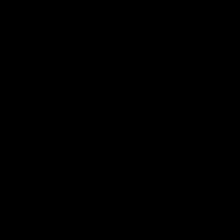

Brightness 0.125000


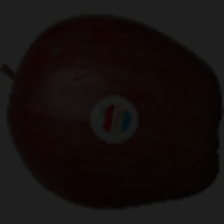

Brightness 0.250000


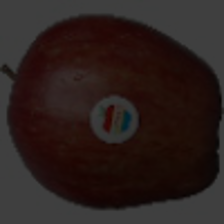

Brightness 0.375000


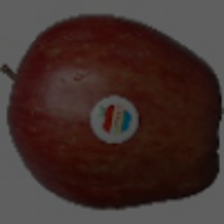

Brightness 0.500000


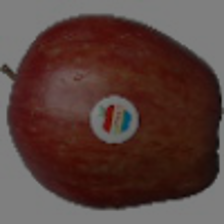

Brightness 0.625000


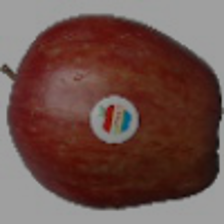

Brightness 0.750000


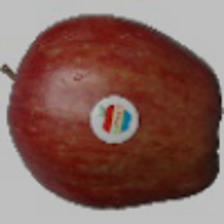

Brightness 0.875000


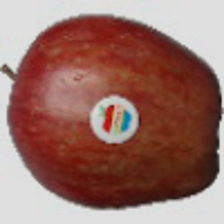

Brightness 1.000000


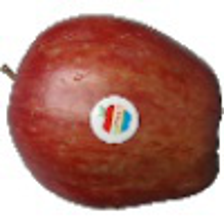

Brightness 1.125000


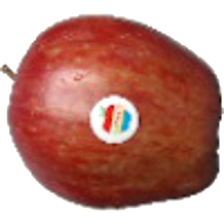

Brightness 1.250000


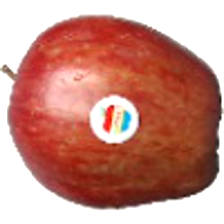

Brightness 1.375000


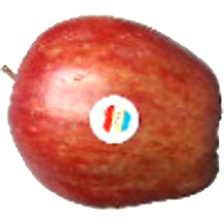

Brightness 1.500000


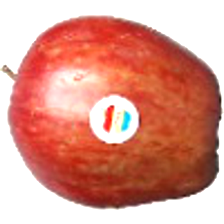

Brightness 1.625000


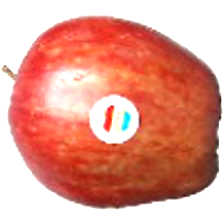

Brightness 1.750000


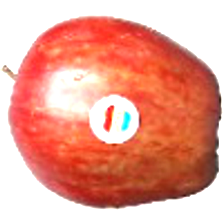

Brightness 1.875000


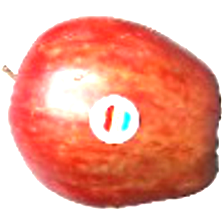

Brightness 2.000000


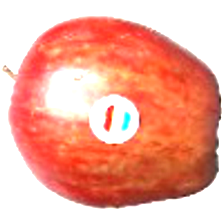

Brightness 2.125000


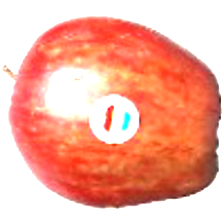

Brightness 2.250000


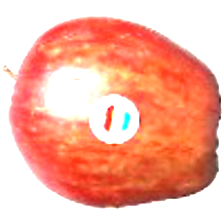

Brightness 2.375000


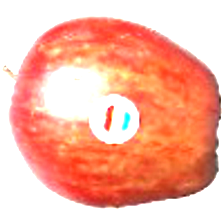

Brightness 2.500000


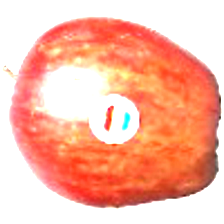

Brightness 2.625000


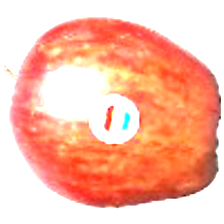

Brightness 2.750000


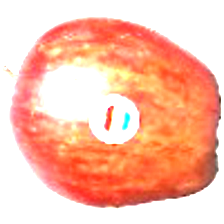

Brightness 2.875000


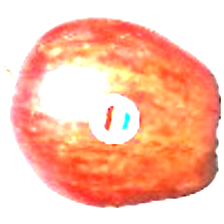

Brightness 3.000000


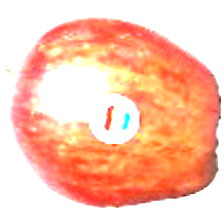

Brightness 3.125000


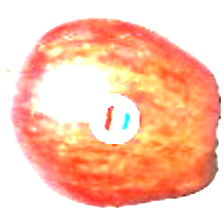

Brightness 3.250000


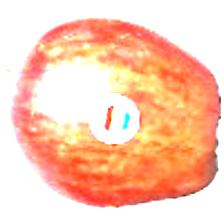

Brightness 3.375000


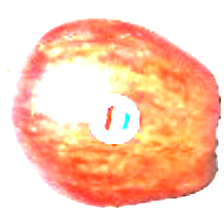

Brightness 3.500000


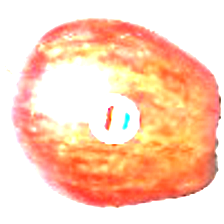

Brightness 3.625000


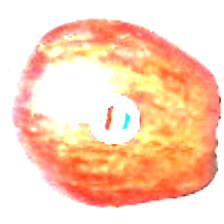

Brightness 3.750000


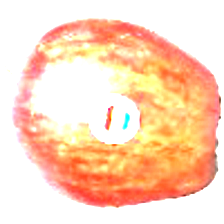

Brightness 3.875000


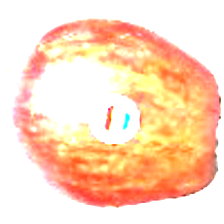

Brightness 4.000000


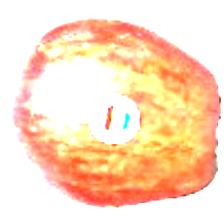

Brightness 4.125000


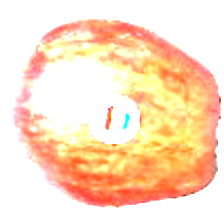

Brightness 4.250000


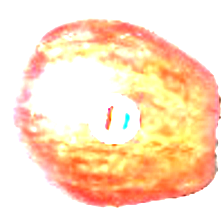

Brightness 4.375000


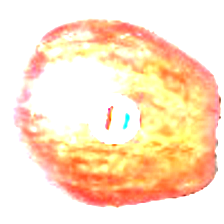

Brightness 4.500000


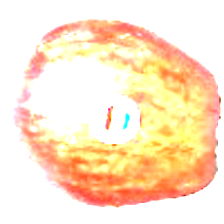

Brightness 4.625000


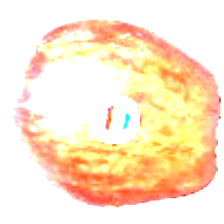

Brightness 4.750000


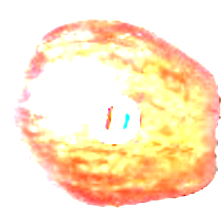

Brightness 4.875000


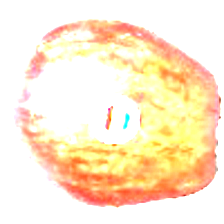

In [14]:
brigthnessEnhancer = ImageEnhance.Brightness(imgs[0])

for i in range(40):
    factor = i / 8
    print(f"Brightness {factor:f}")
    brigthnessEnhancer.enhance(factor).show()

In [15]:
# Enhance image
def enhance(img,
            color = 1.25,
            sharpness = 4.5,
            contrast = 1.25,
            brigthness= 1.5):
    colorEnhancer = ImageEnhance.Color(img)
    img = colorEnhancer.enhance(color)
    
    sharpnessEnhancer = ImageEnhance.Sharpness(img)
    sharpnessEnhancer.enhance(sharpness)
    
    contrastEnhancer = ImageEnhance.Contrast(img)
    contrastEnhancer.enhance(contrast)
    
    brigthnessEnhancer = ImageEnhance.Brightness(img)
    brigthnessEnhancer.enhance(brigthness)
    
    return img

Original


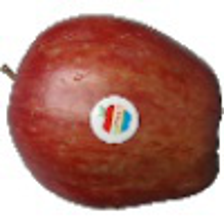

Enhanced


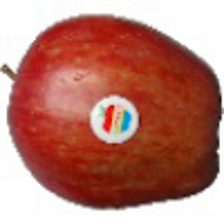

Original


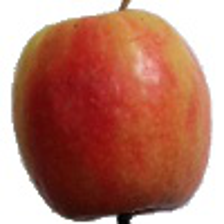

Enhanced


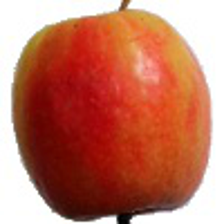

In [16]:
for _,img in enumerate(imgs):
    print ('Original')
    display(img)
    print ('Enhanced')
    display(enhance(img))

# Transfert learning (Resnet50)

In [17]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
   
    resnet_full = ResNet50()

    resnet = Model(inputs = resnet_full.inputs,
                   outputs = resnet_full.layers[-2].output)
    return resnet

In [18]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    # load raw image from dataframe and resize it to ResNet specifications
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    # Enhance image
    img = enhance(img)
    # image to Tensor array
    arr = img_to_array(img)
    # return ResNet50 preprocessed image
    return preprocess_input(arr)


def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    #   input = np.stack(content_series.map(preprocess))
    inputs = tf.convert_to_tensor(np.stack(content_series.map(preprocess)), dtype=tf.float32)
    # features from image
    preds = model.predict(inputs)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    # return features vector
    return pd.Series(output)


In [19]:
from typing import Iterator

@pandas_udf('array<float>')
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  ''' 
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

Apply featurization to the DataFrame of images

In [20]:
# Avoiding Out Of Memory (OOM) errors by reducing the Arrow batch size
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")

In [21]:
# Transfert learning 
images = images.withColumn('features', featurize_udf(images.content))
images.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



# Enregistrement

In [22]:
(images
 .select('path','label','features')
 .write
 .partitionBy('label')
 .mode("overwrite")
 .parquet("Features/Apples-by-label-Training-featured.parquet")
) 

# End Spark session

In [23]:
spark.stop()